In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from datetime import datetime

In [2]:
# Step 1: Download Financial Data (USDINR Exchange Rate)
start_date = '2010-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
data = yf.download('USDINR=X', start=start_date, end=end_date)
data = data[['Close']]

data.head()

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2010-01-01,46.610001
2010-01-04,46.287998
2010-01-05,46.119999
2010-01-06,45.720001
2010-01-07,45.688000


In [3]:
data.dropna(inplace=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_23560\1368182302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [4]:
# Step 2: Normalize Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [5]:
# Step 3: Create Lagged Features
def create_lagged_features(data, lags):
    X, y = [], []
    for i in range(lags, len(data)):
        X.append(data[i-lags:i])
        y.append(data[i])
    return np.array(X), np.array(y)

lags = 60  # Use 60 days of historical data to predict the next day
X, y = create_lagged_features(scaled_data, lags)

# Reshape the data to match LSTM input requirements
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [6]:
# Split into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]

In [7]:
# Step 4: Build the Optimized LSTM Model
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1))),
    Dropout(0.2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

In [8]:
# Step 5: Compile the Model with RMSprop optimizer
optimizer = RMSprop(learning_rate=0.001)  # Optimized for time series
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [9]:
# Step 6: Train the Model with Early Stopping and Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

In [10]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100

96/96 [==============================] - 37s 134ms/step - loss: 0.0133 - val_loss: 0.0387 - lr: 0.0010
Epoch 2/100
96/96 [==============================] - 8s 84ms/step - loss: 0.0063 - val_loss: 0.0013 - lr: 0.0010
Epoch 3/100
96/96 [==============================] - 9s 89ms/step - loss: 0.0052 - val_loss: 4.9204e-04 - lr: 0.0010
Epoch 4/100
96/96 [==============================] - 10s 105ms/step - loss: 0.0045 - val_loss: 3.4745e-04 - lr: 0.0010
Epoch 5/100
96/96 [==============================] - 10s 102ms/step - loss: 0.0038 - val_loss: 6.2718e-04 - lr: 0.0010
Epoch 6/100
96/96 [==============================] - 10s 103ms/step - loss: 0.0031 - val_loss: 0.0054 - lr: 0.0010
Epoch 7/100
96/96 [==============================] - 10s 104ms/step - loss: 0.0030 - val_loss: 2.6664e-04 - lr: 0.0010
Epoch 8/100
96/96 [==============================] - 10s 105ms/step - loss: 0.0028 - val_loss: 2.1791e-04 - lr: 0.0010
Epoch 9/100
96/96 [==============================] - 10s 107ms/

In [11]:
# Step 7: Evaluate the Model
mse = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Mean Squared Error: {mse}")

24/24 [==============================] - 1s 36ms/step - loss: 1.6794e-04
Test Mean Squared Error: 0.0001679448178038001


In [12]:
import matplotlib.pyplot as plt

# Step 8: Make Predictions
# Predict on both training and testing data
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Reverse the scaling to get predictions in original scale
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

y_train_original = scaler.inverse_transform(y_train)
y_test_original = scaler.inverse_transform(y_test)

# Prepare indices for plotting
train_indices = range(lags, split_index + lags)
test_indices = range(split_index + lags, len(data))

24/24 [==============================] - 1s 34ms/step


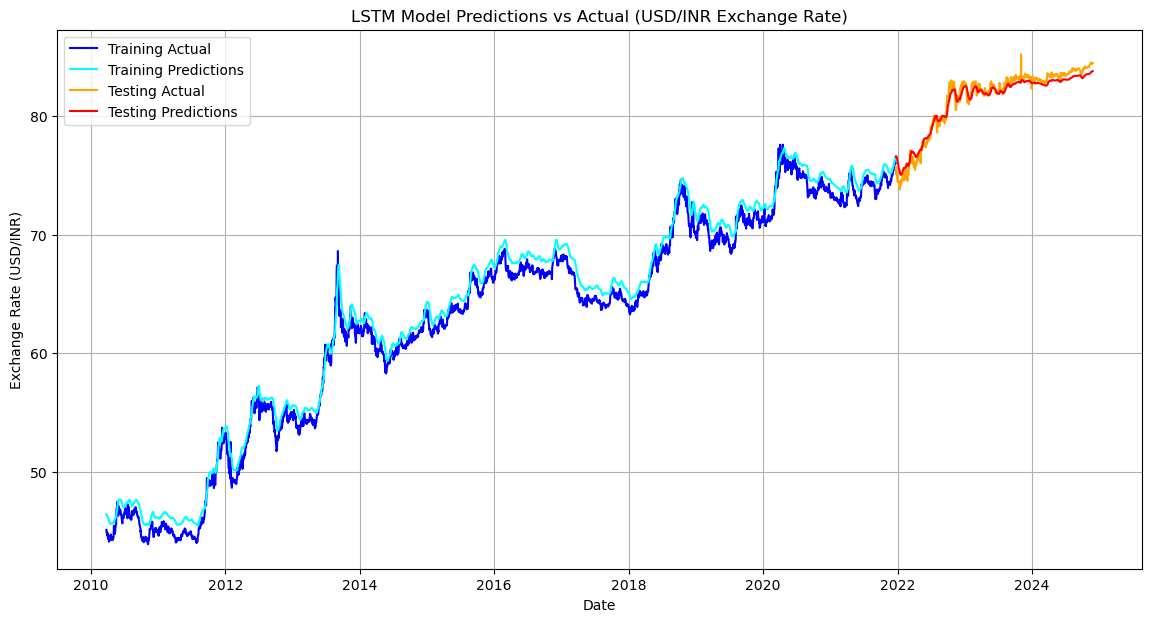

In [13]:
# Step 9: Plot the Results
plt.figure(figsize=(14, 7))

# Plot training data predictions
plt.plot(data.index[train_indices], y_train_original.flatten(), label="Training Actual", color="blue")
plt.plot(data.index[train_indices], train_predictions.flatten(), label="Training Predictions", color="cyan")

# Plot testing data predictions
plt.plot(data.index[test_indices], y_test_original.flatten(), label="Testing Actual", color="orange")
plt.plot(data.index[test_indices], test_predictions.flatten(), label="Testing Predictions", color="red")

# Formatting
plt.title("LSTM Model Predictions vs Actual (USD/INR Exchange Rate)")
plt.xlabel("Date")
plt.ylabel("Exchange Rate (USD/INR)")
plt.legend()
plt.grid()
plt.show()